# Sistema de Ruteo Seguro para CDMX

## Parte 1: Análisis Espacial y Clustering

Este notebook continúa el análisis iniciado en `proceso.ipynb`. Aquí aplicamos técnicas avanzadas de clustering espacial para identificar patrones de riesgo en la red vial.

**Requisitos previos:** Haber ejecutado `proceso.ipynb` que genera:
- `Datos combinados CDMX/ACCIDENTES_CON_TRAMOS_2019_2023.csv`
- `Datos combinados CDMX/STATS_POR_TRAMO_2019_2023.csv`
- `Red vial/red_vial_cdmx.graphml`

**Objetivos:**
1. Clustering espacial con DBSCAN
2. Análisis de hot spots con Getis-Ord Gi*
3. Autocorrelación espacial con Moran's I
4. Integración al índice de riesgo compuesto

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import DBSCAN
from scipy.spatial import distance_matrix
from scipy import stats
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import DistanceBand
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías cargadas")

✓ Librerías cargadas


## Configuración de Rutas

In [2]:
RUTA_ACCIDENTES_CON_TRAMOS = "Datos combinados CDMX/ACCIDENTES_CON_TRAMOS_2019_2023.csv"
RUTA_STATS_TRAMOS = "Datos combinados CDMX/STATS_POR_TRAMO_2019_2023.csv"
RUTA_GRAFO_OSM = "Red vial/red_vial_cdmx.graphml"

print("✓ Rutas configuradas")

✓ Rutas configuradas


## 1. Carga de Datos Procesados

Cargamos los datos generados por proceso.ipynb

In [3]:
df_accidentes = pd.read_csv(RUTA_ACCIDENTES_CON_TRAMOS)
df_stats_tramos = pd.read_csv(RUTA_STATS_TRAMOS)
G = nx.read_graphml(RUTA_GRAFO_OSM)

print(f"✓ Datos cargados:")
print(f"   Accidentes: {len(df_accidentes):,} registros")
print(f"   Tramos analizados: {len(df_stats_tramos):,}")
print(f"   Red vial - Nodos: {len(G.nodes):,}, Aristas: {len(G.edges):,}")
print(f"\nColumnas de accidentes: {list(df_accidentes.columns[:10])}...")

✓ Datos cargados:
   Accidentes: 32,139 registros
   Tramos analizados: 14,982
   Red vial - Nodos: 99,712, Aristas: 234,484

Columnas de accidentes: ['id', 'edo', 'mes', 'anio', 'mpio', 'hora', 'minutos', 'dia', 'diasemana', 'urbana']...


## 2. Clustering Espacial con DBSCAN

DBSCAN identifica clusters de alta densidad de accidentes (puntos negros)

In [4]:
gdf_accidentes = gpd.GeoDataFrame(df_accidentes,
    geometry=gpd.points_from_xy(df_accidentes.longitud, df_accidentes.latitud),
    crs='EPSG:4326')

gdf_accidentes_utm = gdf_accidentes.to_crs('EPSG:32614')

coords_utm = np.array([[point.x, point.y] for point in gdf_accidentes_utm.geometry])

dbscan = DBSCAN(eps=200, min_samples=20, metric='euclidean')
gdf_accidentes['cluster_dbscan'] = dbscan.fit_predict(coords_utm)

n_clusters = len(set(gdf_accidentes['cluster_dbscan'])) - (1 if -1 in gdf_accidentes['cluster_dbscan'].values else 0)
n_noise = list(gdf_accidentes['cluster_dbscan']).count(-1)

print(f"✓ DBSCAN completado")
print(f"   Clusters identificados: {n_clusters}")
print(f"   Puntos en clusters: {len(gdf_accidentes) - n_noise:,}")
print(f"   Ruido: {n_noise:,} ({n_noise/len(gdf_accidentes)*100:.1f}%)")

✓ DBSCAN completado
   Clusters identificados: 299
   Puntos en clusters: 17,178
   Ruido: 14,961 (46.6%)


### 2.1 Visualización de Clusters DBSCAN

Scatter plot detallado mostrando los clusters identificados y el ruido

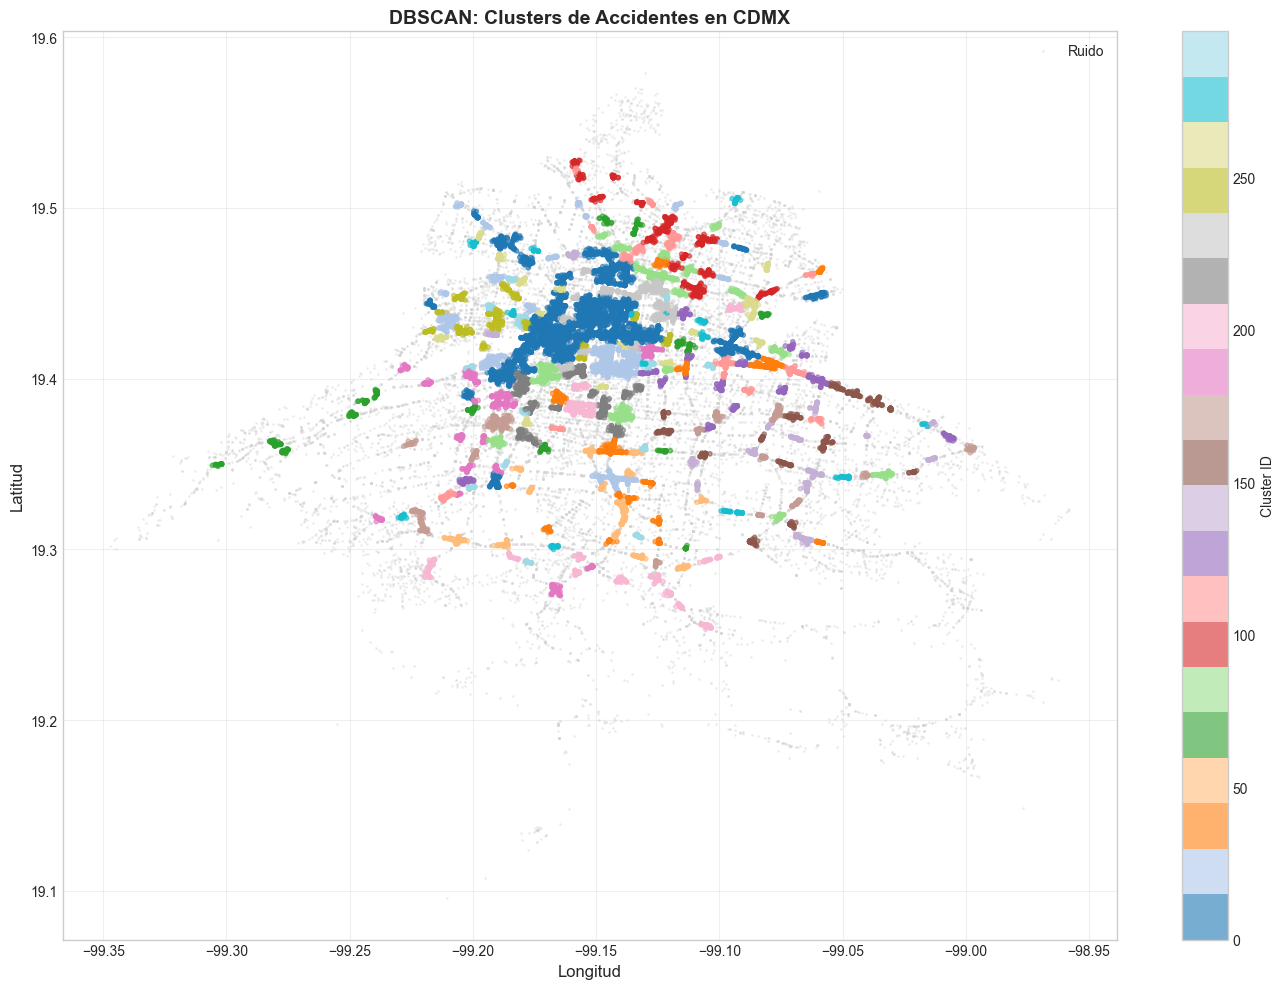


 Estadísticas de clustering:
   Total de puntos: 32,139
   Puntos en clusters: 17,178 (53.4%)
   Ruido: 14,961 (46.6%)
   Número de clusters: 299


In [5]:
# Visualización de clusters DBSCAN
def plot_clusters_dbscan(df, figsize=(14, 10)):
    """
    Visualiza los clusters encontrados por DBSCAN.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Separar ruido y clusters
    ruido = df[df['cluster_dbscan'] == -1]
    clusters = df[df['cluster_dbscan'] != -1]
    
    # Graficar ruido
    ax.scatter(ruido['longitud'], ruido['latitud'],
               c='lightgray', s=1, alpha=0.3, label='Ruido')
    
    # Graficar clusters
    scatter = ax.scatter(clusters['longitud'], clusters['latitud'],
                        c=clusters['cluster_dbscan'], cmap='tab20',
                        s=10, alpha=0.6)
    
    ax.set_xlabel('Longitud', fontsize=12)
    ax.set_ylabel('Latitud', fontsize=12)
    ax.set_title('DBSCAN: Clusters de Accidentes en CDMX', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=ax, label='Cluster ID')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n Estadísticas de clustering:")
    print(f"   Total de puntos: {len(df):,}")
    print(f"   Puntos en clusters: {len(clusters):,} ({len(clusters)/len(df)*100:.1f}%)")
    print(f"   Ruido: {len(ruido):,} ({len(ruido)/len(df)*100:.1f}%)")
    print(f"   Número de clusters: {df[df['cluster_dbscan'] != -1]['cluster_dbscan'].nunique()}")

plot_clusters_dbscan(gdf_accidentes)

### 2.2 Mapa de Calor - Densidad de Accidentes

Visualización de la densidad espacial mediante histograma 2D

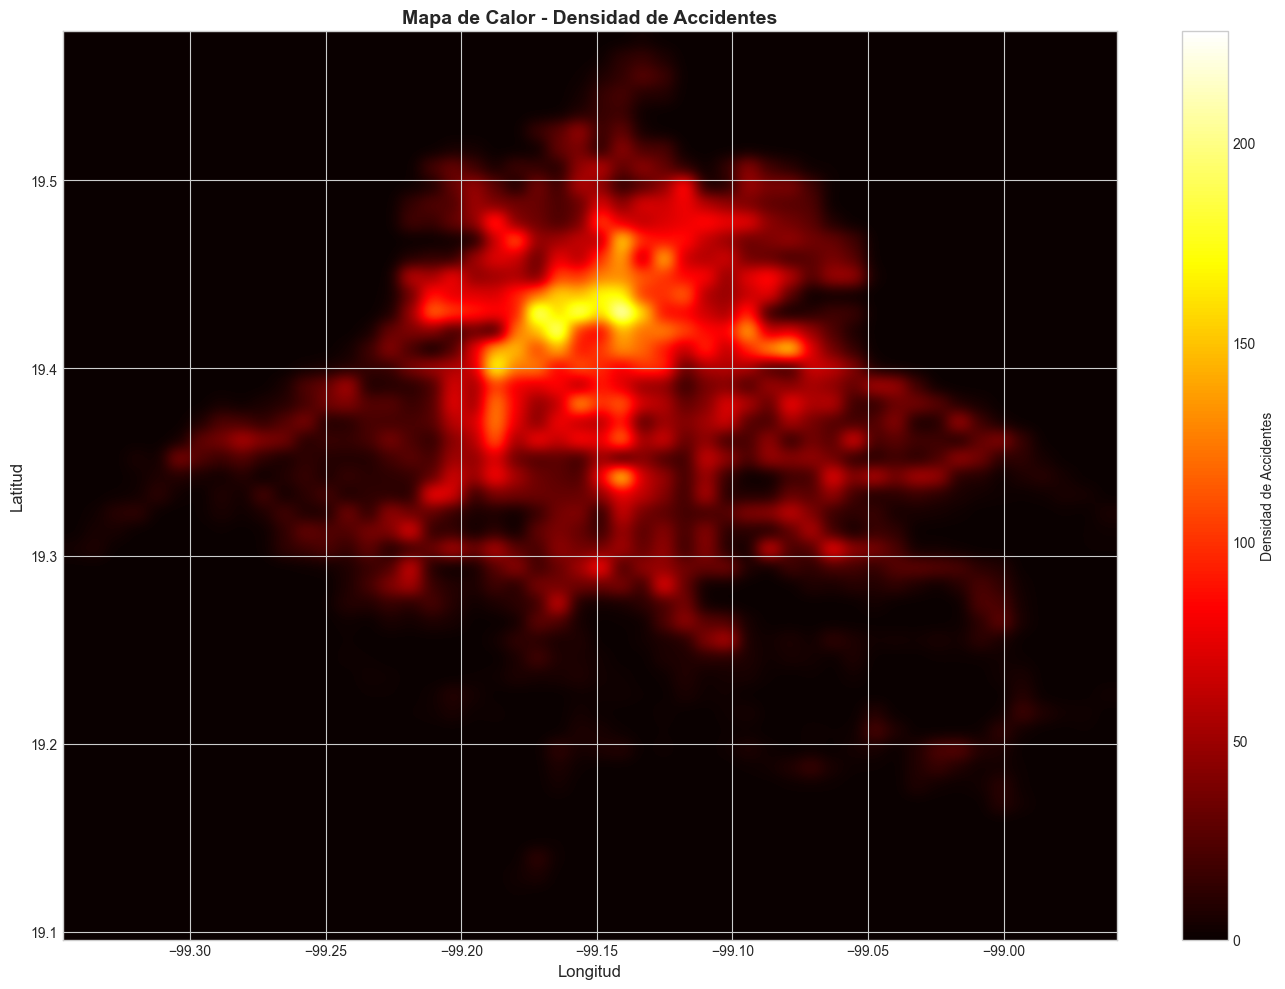

In [6]:
# Mapa de calor de densidad
fig, ax = plt.subplots(figsize=(14, 10))
heatmap, xedges, yedges = np.histogram2d(gdf_accidentes["longitud"], gdf_accidentes["latitud"], bins=50)
im = ax.imshow(heatmap.T, origin="lower", 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap="hot", aspect="auto", interpolation="gaussian")
plt.colorbar(im, ax=ax, label="Densidad de Accidentes")
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)
ax.set_title("Mapa de Calor - Densidad de Accidentes", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

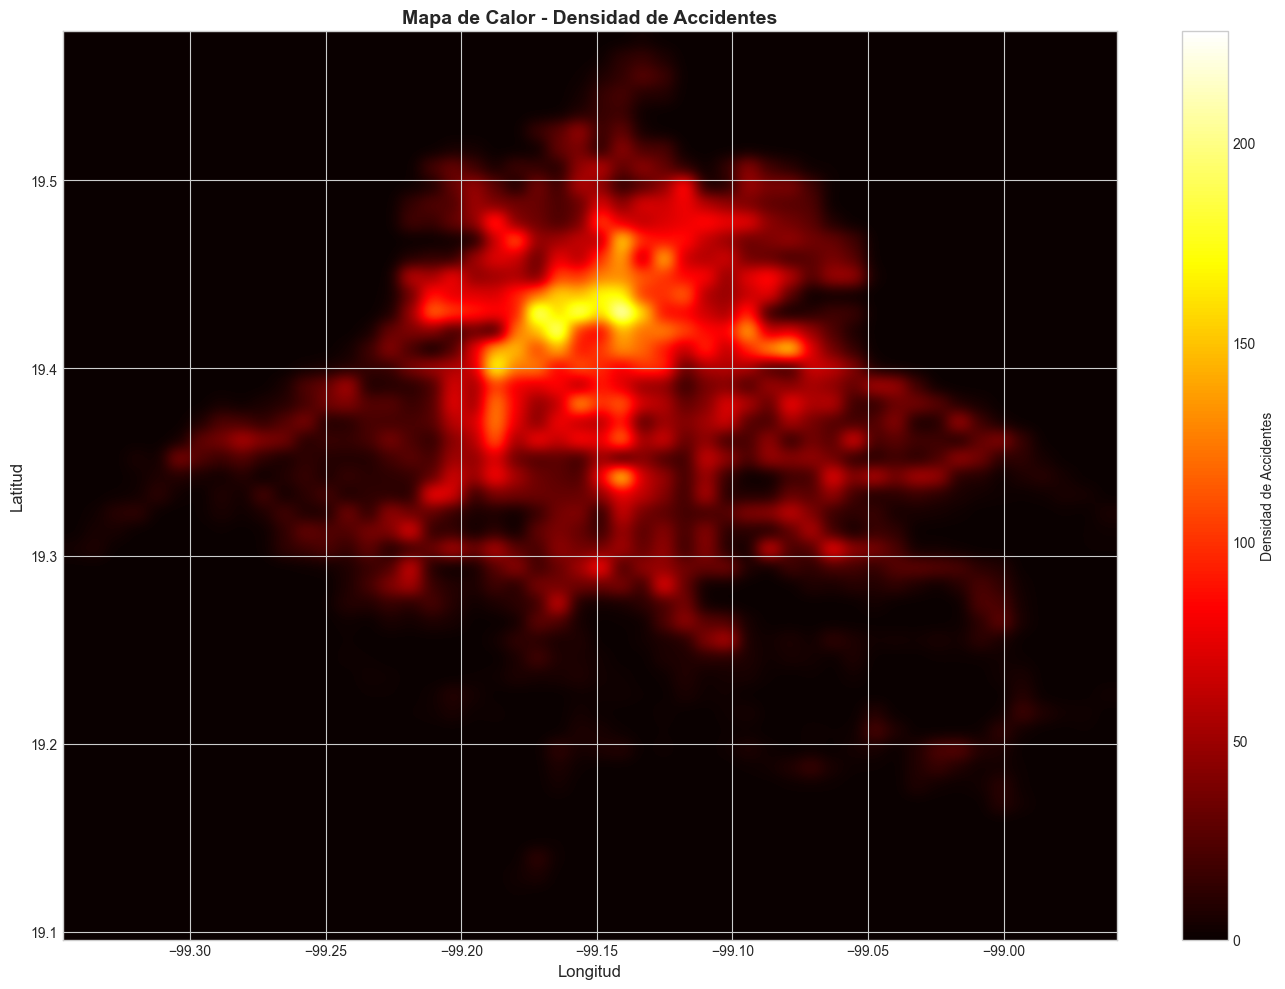

✓ Mapa de calor generado


In [7]:
# Mapa de calor de densidad
fig, ax = plt.subplots(figsize=(14, 10))
heatmap, xedges, yedges = np.histogram2d(gdf_accidentes["longitud"], gdf_accidentes["latitud"], bins=50)
im = ax.imshow(heatmap.T, origin="lower", 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap="hot", aspect="auto", interpolation="gaussian")
plt.colorbar(im, ax=ax, label="Densidad de Accidentes")
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)
ax.set_title("Mapa de Calor - Densidad de Accidentes", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("✓ Mapa de calor generado")

## 3. Mapa de Clusters

In [8]:
centro_cdmx = [19.4326, -99.1332]
mapa_clusters = folium.Map(location=centro_cdmx, zoom_start=11, tiles='CartoDB positron')

clusters_validos = gdf_accidentes[gdf_accidentes['cluster_dbscan'] != -1]
cluster_stats = clusters_validos.groupby('cluster_dbscan').agg({
    'latitud': 'mean',
    'longitud': 'mean',
    'cluster_dbscan': 'count'
}).rename(columns={'cluster_dbscan': 'n_accidentes'}).sort_values('n_accidentes', ascending=False)

for idx, row in cluster_stats.head(50).iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=min(row['n_accidentes'] / 10, 25),
        popup=f"<b>Cluster {idx}</b><br>{row['n_accidentes']} accidentes",
        color='darkred',
        fill=True,
        fillColor='red',
        fillOpacity=0.6
    ).add_to(mapa_clusters)

print(f"✓ Mapa de clusters creado con los {min(50, len(cluster_stats))} clusters más grandes")
mapa_clusters.save('mapas/mapa_clusters_dbscan.html')
print("   Guardado en: mapas/mapa_clusters_dbscan.html")
mapa_clusters

✓ Mapa de clusters creado con los 50 clusters más grandes
   Guardado en: mapas/mapa_clusters_dbscan.html


## 4. Análisis de Hot Spots: Getis-Ord Gi*

Identifica áreas con concentraciones estadísticamente significativas de accidentes

In [9]:
def crear_cuadricula(gdf, cell_size=0.01):
    minx, miny, maxx, maxy = gdf.total_bounds
    cols = int(np.ceil((maxx - minx) / cell_size))
    rows = int(np.ceil((maxy - miny) / cell_size))
    
    from shapely.geometry import box
    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            cell = box(minx + i*cell_size, miny + j*cell_size,
                      minx + (i+1)*cell_size, miny + (j+1)*cell_size)
            grid_cells.append(cell)
    
    return gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)

grid = crear_cuadricula(gdf_accidentes, cell_size=0.01)
grid['n_accidentes'] = grid.geometry.apply(lambda cell: gdf_accidentes[gdf_accidentes.within(cell)].shape[0])
grid = grid[grid['n_accidentes'] > 0]

print(f"✓ Cuadrícula creada: {len(grid):,} celdas con accidentes")

✓ Cuadrícula creada: 755 celdas con accidentes


In [10]:
coords = np.array([[geom.centroid.x, geom.centroid.y] for geom in grid.geometry])

try:
    # Crear matriz de pesos espaciales
    w = DistanceBand(coords, threshold=0.02, binary=True)
    
    # Convertir datos a float64 para evitar problemas con numba
    valores = grid['n_accidentes'].values.astype(np.float64)
    
    # Calcular Getis-Ord Gi* sin permutaciones para evitar el error de numba
    # Usando el método de inferencia clásica en lugar de simulación
    g_local = G_Local(valores, w, star=True, permutations=0)
    
    grid['gi_score'] = g_local.Zs
    grid['gi_pvalue'] = g_local.p_norm  # Usar p-value normal en lugar de simulado
    
    grid['hot_spot'] = 'No significativo'
    grid.loc[grid['gi_score'] > 2.58, 'hot_spot'] = 'Hot Spot (99%)'
    grid.loc[(grid['gi_score'] > 1.96) & (grid['gi_score'] <= 2.58), 'hot_spot'] = 'Hot Spot (95%)'
    grid.loc[grid['gi_score'] < -2.58, 'hot_spot'] = 'Cold Spot (99%)'
    grid.loc[(grid['gi_score'] < -1.96) & (grid['gi_score'] >= -2.58), 'hot_spot'] = 'Cold Spot (95%)'
    
    print(f"✓ Getis-Ord Gi* calculado")
    print(f"\nDistribución de Hot Spots:")
    print(grid['hot_spot'].value_counts())
except Exception as e:
    print(f"⚠ Error en Getis-Ord: {e}")
    print("Continuando sin análisis de hot spots...")
    grid['gi_score'] = 0
    grid['hot_spot'] = 'No calculado'

('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 746, ' is an island (no neighbors)')
✓ Getis-Ord Gi* calculado

Distribución de Hot Spots:
hot_spot
No significativo    725
Hot Spot (95%)       17
Hot Spot (99%)       13
Name: count, dtype: int64


## 5. Autocorrelación Espacial: Moran's I

### 4.1 Visualización Detallada de Hot Spots

Mapas de Getis-Ord Gi* scores y clasificación de hot/cold spots

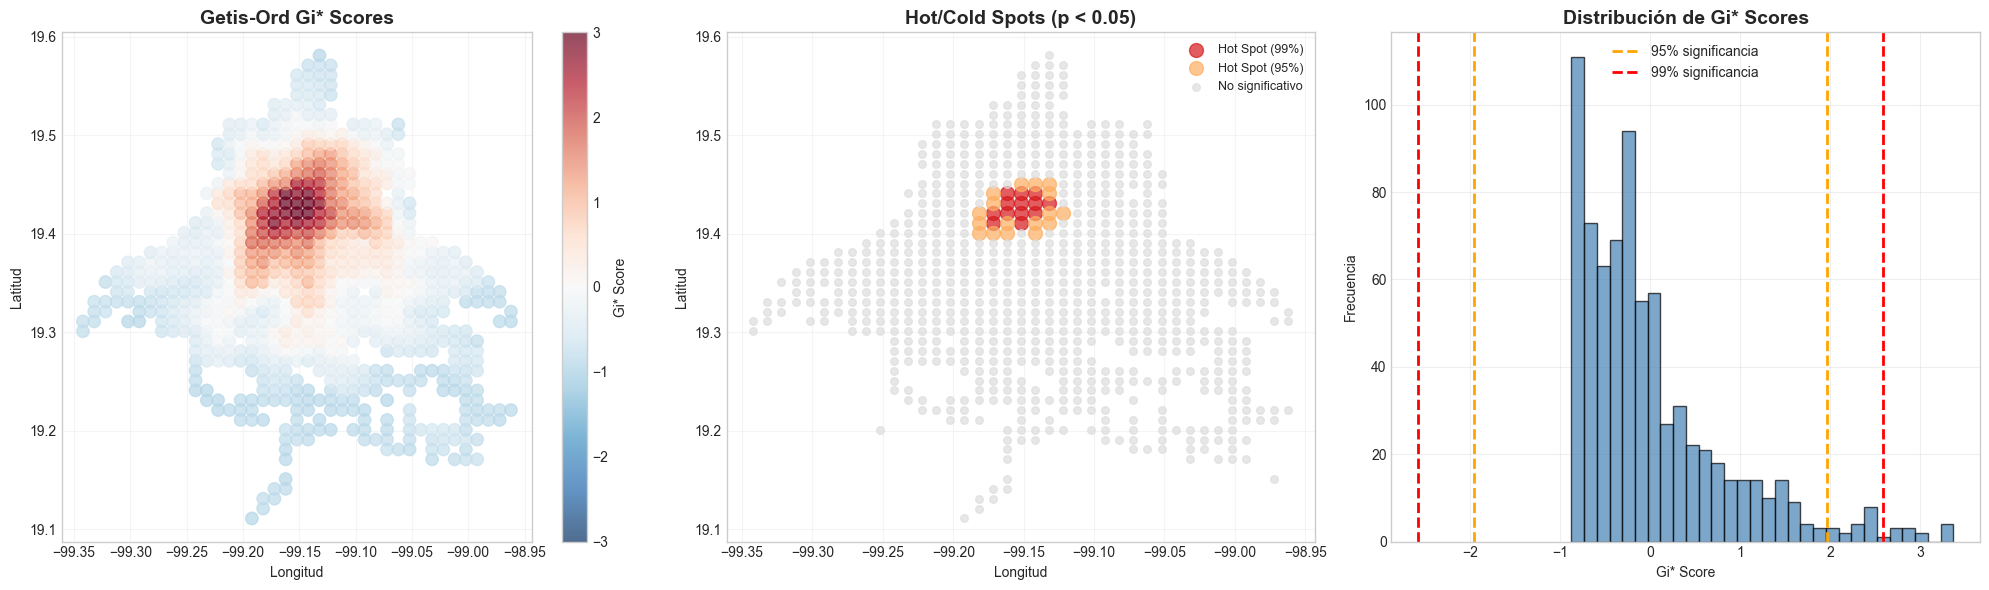

 Estadísticas de Hot Spots:
   Gi* Score promedio: 0.014
   Gi* Score máximo: 3.365
   Gi* Score mínimo: -0.879


In [11]:
# Visualización mejorada de Hot Spots (Getis-Ord Gi*)
if "gi_score" in grid.columns:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Gi* Scores continuos
    scatter1 = axes[0].scatter(grid.geometry.centroid.x, grid.geometry.centroid.y,
                               c=grid["gi_score"], cmap="RdBu_r", 
                               s=80, alpha=0.7, vmin=-3, vmax=3)
    plt.colorbar(scatter1, ax=axes[0], label="Gi* Score")
    axes[0].set_title("Getis-Ord Gi* Scores", fontsize=14, fontweight="bold")
    axes[0].set_xlabel("Longitud")
    axes[0].set_ylabel("Latitud")
    axes[0].grid(True, alpha=0.2)
    
    # Plot 2: Hot/Cold Spots clasificados
    colors_map = {"Hot Spot (99%)": "#d7191c", "Hot Spot (95%)": "#fdae61", 
                  "No significativo": "#dddddd", "Cold Spot (95%)": "#abd9e9", 
                  "Cold Spot (99%)": "#2b83ba"}
    for tipo, color in colors_map.items():
        data = grid[grid["hot_spot"] == tipo]
        if len(data) > 0:
            size = 100 if "Hot" in tipo or "Cold" in tipo else 30
            axes[1].scatter(data.geometry.centroid.x, data.geometry.centroid.y,
                           c=color, label=tipo, s=size, alpha=0.7)
    axes[1].set_title("Hot/Cold Spots (p < 0.05)", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Longitud")
    axes[1].set_ylabel("Latitud")
    axes[1].legend(loc="best", fontsize=9)
    axes[1].grid(True, alpha=0.2)
    
    # Plot 3: Histograma de Gi* scores
    axes[2].hist(grid["gi_score"], bins=30, color="steelblue", edgecolor="black", alpha=0.7)
    axes[2].axvline(1.96, color="orange", linestyle="--", linewidth=2, label="95% significancia")
    axes[2].axvline(2.58, color="red", linestyle="--", linewidth=2, label="99% significancia")
    axes[2].axvline(-1.96, color="orange", linestyle="--", linewidth=2)
    axes[2].axvline(-2.58, color="red", linestyle="--", linewidth=2)
    axes[2].set_title("Distribución de Gi* Scores", fontsize=14, fontweight="bold")
    axes[2].set_xlabel("Gi* Score")
    axes[2].set_ylabel("Frecuencia")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f" Estadísticas de Hot Spots:")
    print(f"   Gi* Score promedio: {grid["gi_score"].mean():.3f}")
    print(f"   Gi* Score máximo: {grid["gi_score"].max():.3f}")
    print(f"   Gi* Score mínimo: {grid["gi_score"].min():.3f}")
else:
    print("⚠ No hay datos de Gi* para visualizar")

### 4.2 Mapa Comparativo de Técnicas Espaciales

Vista comparativa de DBSCAN, Grid, Hot Spots y análisis combinado

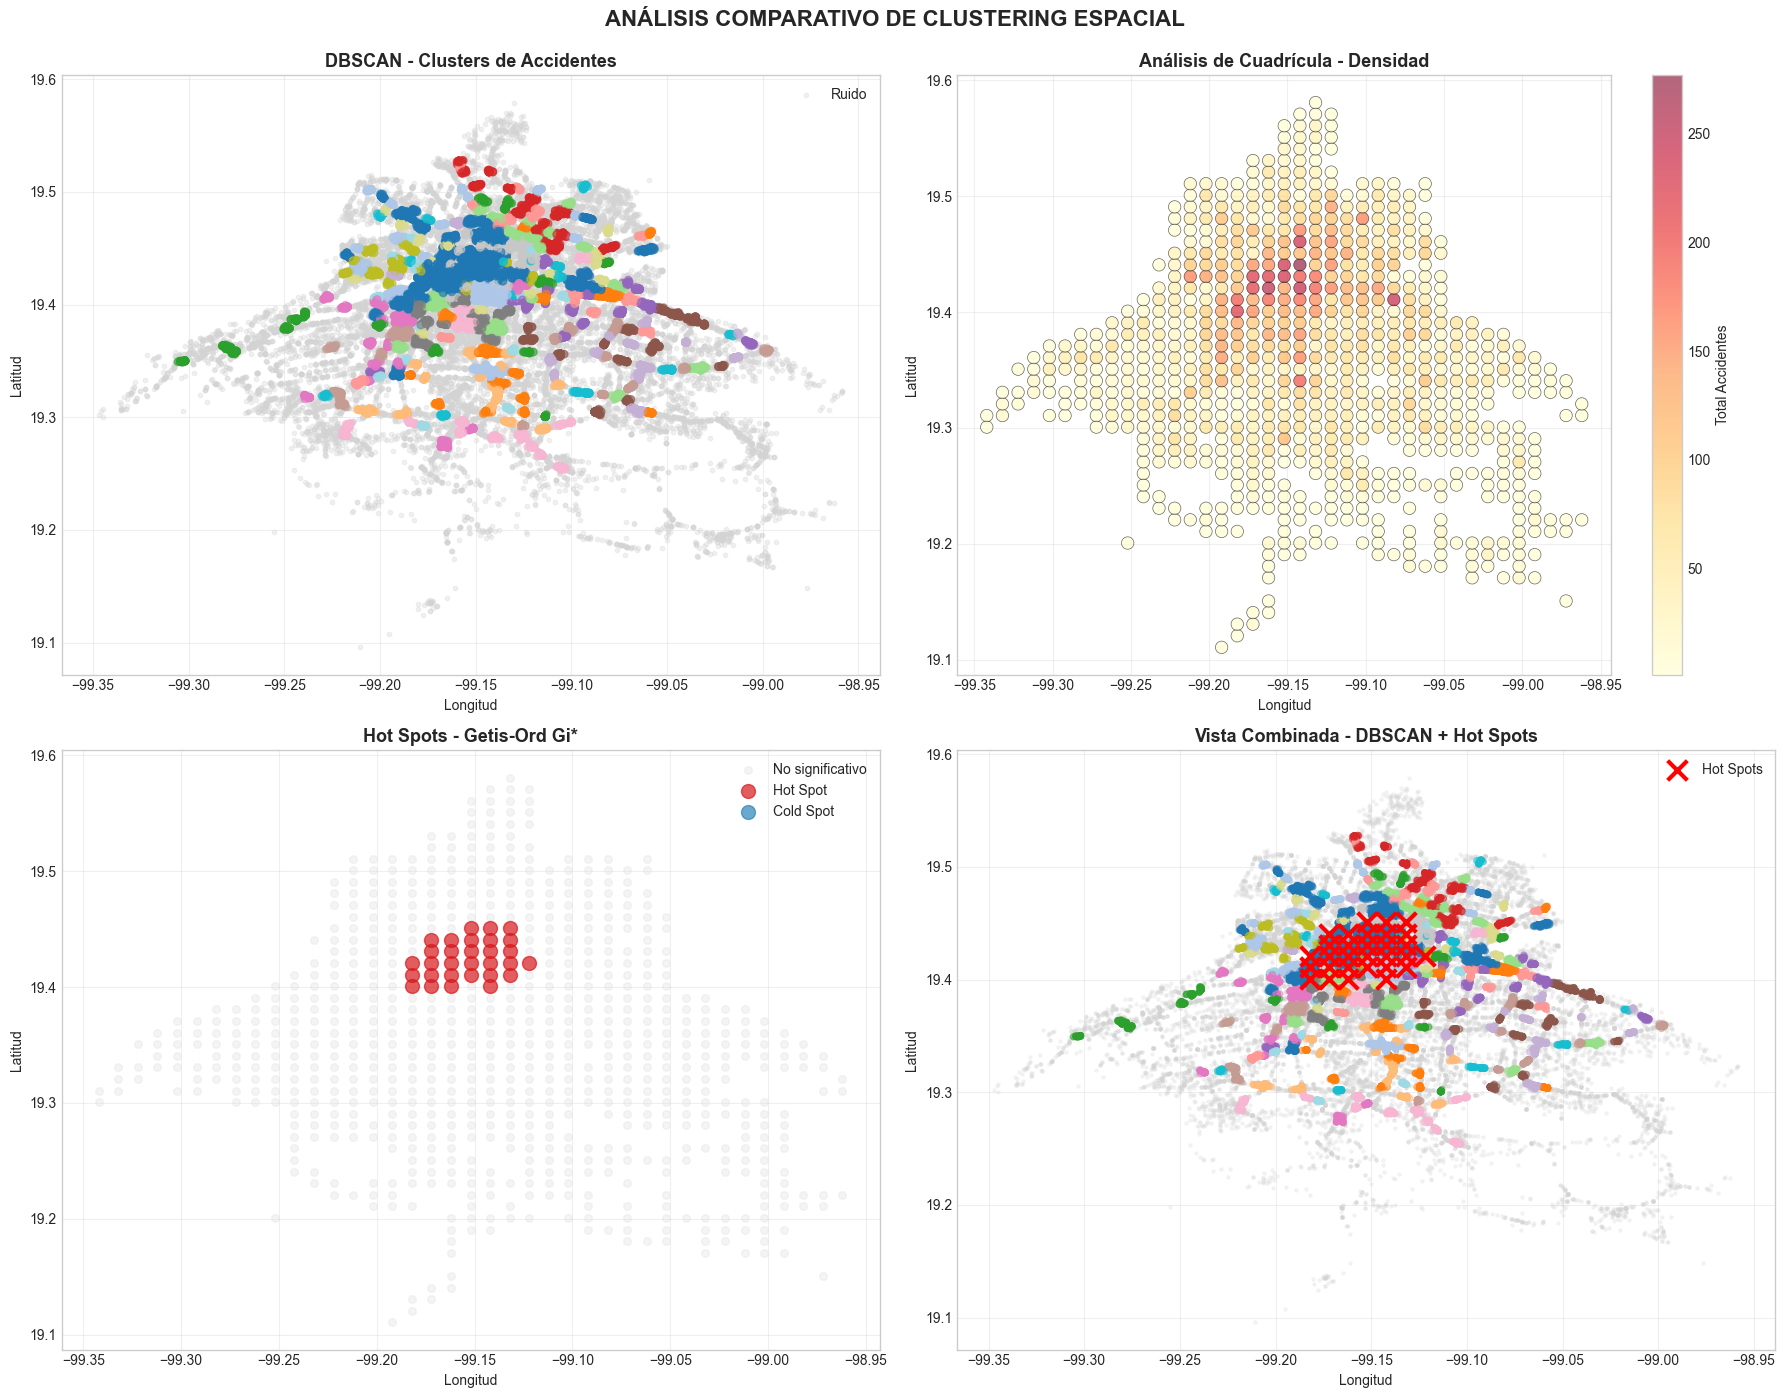

✓ Mapa comparativo generado con 4 técnicas espaciales


In [12]:
# Mapa comparativo 2x2: DBSCAN vs Grid vs Hot Spots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Subplot 1: DBSCAN Clusters
ax1 = axes[0, 0]
ruido = gdf_accidentes[gdf_accidentes["cluster_dbscan"] == -1]
clusters = gdf_accidentes[gdf_accidentes["cluster_dbscan"] != -1]
ax1.scatter(ruido["longitud"], ruido["latitud"],
            c="lightgray", s=10, alpha=0.3, label="Ruido")
scatter1 = ax1.scatter(clusters["longitud"], clusters["latitud"],
                       c=clusters["cluster_dbscan"], cmap="tab20",
                       s=30, alpha=0.6)
ax1.set_title("DBSCAN - Clusters de Accidentes", fontsize=13, fontweight="bold")
ax1.set_xlabel("Longitud")
ax1.set_ylabel("Latitud")
ax1.grid(True, alpha=0.3)
ax1.legend(loc="upper right")

# Subplot 2: Grid Analysis (Densidad por celda)
ax2 = axes[0, 1]
scatter2 = ax2.scatter(
    grid.geometry.centroid.x,
    grid.geometry.centroid.y,
    c=grid["n_accidentes"],
    cmap="YlOrRd",
    s=80, alpha=0.6, edgecolors="black", linewidth=0.5
)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label("Total Accidentes", fontsize=10)
ax2.set_title("Análisis de Cuadrícula - Densidad", fontsize=13, fontweight="bold")
ax2.set_xlabel("Longitud")
ax2.set_ylabel("Latitud")
ax2.grid(True, alpha=0.3)

# Subplot 3: Hot Spots (Getis-Ord Gi*)
ax3 = axes[1, 0]
if "gi_score" in grid.columns:
    hot = grid[grid["hot_spot"].str.contains("Hot", na=False)]
    cold = grid[grid["hot_spot"].str.contains("Cold", na=False)]
    neutro = grid[grid["hot_spot"] == "No significativo"]
    
    ax3.scatter(neutro.geometry.centroid.x, neutro.geometry.centroid.y,
               c="#dddddd", s=30, alpha=0.3, label="No significativo")
    ax3.scatter(hot.geometry.centroid.x, hot.geometry.centroid.y,
               c="#d7191c", s=100, alpha=0.7, label="Hot Spot")
    ax3.scatter(cold.geometry.centroid.x, cold.geometry.centroid.y,
               c="#2b83ba", s=100, alpha=0.7, label="Cold Spot")
    ax3.set_title("Hot Spots - Getis-Ord Gi*", fontsize=13, fontweight="bold")
    ax3.set_xlabel("Longitud")
    ax3.set_ylabel("Latitud")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, "No hay datos de Hot Spots", ha="center", va="center")

# Subplot 4: Combinado (DBSCAN + Hot Spots)
ax4 = axes[1, 1]
ax4.scatter(ruido["longitud"], ruido["latitud"],
            c="lightgray", s=5, alpha=0.2)
scatter4 = ax4.scatter(clusters["longitud"], clusters["latitud"],
                       c=clusters["cluster_dbscan"], cmap="tab20",
                       s=20, alpha=0.5)
if "gi_score" in grid.columns and len(hot) > 0:
    ax4.scatter(hot.geometry.centroid.x, hot.geometry.centroid.y,
               marker="x", c="red", s=200, linewidths=3, label="Hot Spots")
ax4.set_title("Vista Combinada - DBSCAN + Hot Spots", fontsize=13, fontweight="bold")
ax4.set_xlabel("Longitud")
ax4.set_ylabel("Latitud")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle("ANÁLISIS COMPARATIVO DE CLUSTERING ESPACIAL", 
             fontsize=16, fontweight="bold", y=0.995)
plt.tight_layout()
plt.show()

print("✓ Mapa comparativo generado con 4 técnicas espaciales")

In [13]:
try:
    moran = Moran(grid['n_accidentes'].values, w)
    
    print(f"\n✓ Moran's I Global: {moran.I:.4f}")
    print(f"   p-value: {moran.p_sim:.4f}")
    print(f"   Valor esperado: {moran.EI:.4f}")
    
    if moran.I > 0.3 and moran.p_sim < 0.05:
        print(f"\n   ✓ Clustering espacial SIGNIFICATIVO detectado")
        print(f"   Los accidentes se agrupan en zonas específicas")
    else:
        print(f"\n   Patrón espacial no concluyente")
except Exception as e:
    print(f"⚠ Error en Moran's I: {e}")

('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 746, ' is an island (no neighbors)')

✓ Moran's I Global: 0.6837
   p-value: 0.0010
   Valor esperado: -0.0013

   ✓ Clustering espacial SIGNIFICATIVO detectado
   Los accidentes se agrupan en zonas específicas


### 5.1 Visualización de Moran's I

Scatter plot de autocorrelación espacial

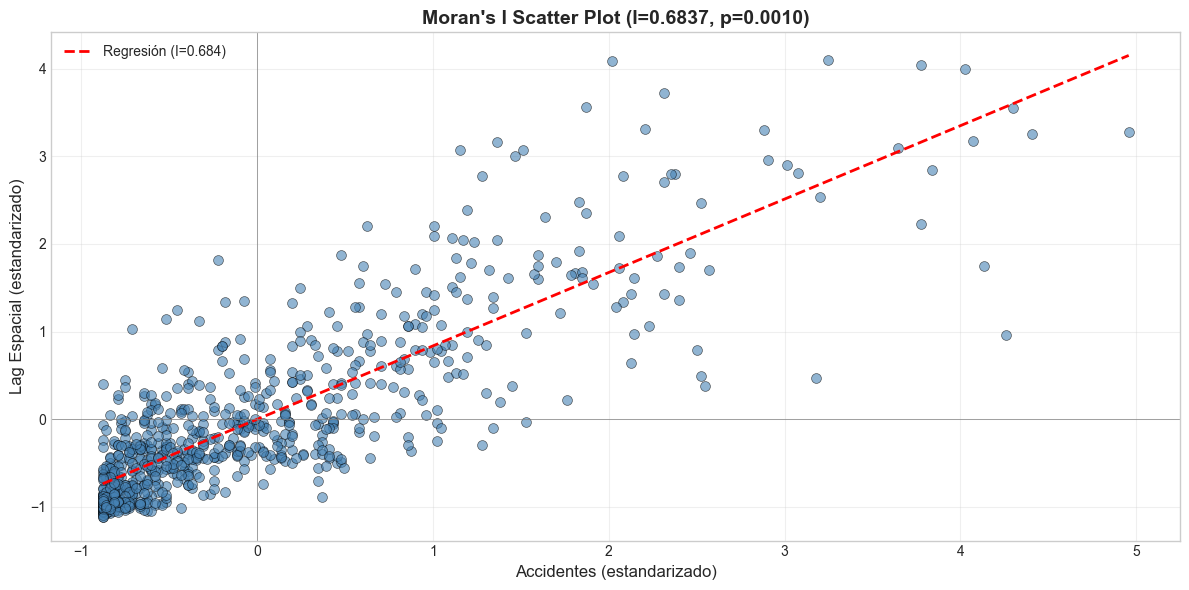

✓ Moran's I scatter plot generado


In [14]:
# Scatter plot de Moran's I
try:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Obtener valores y lags espaciales
    values = grid["n_accidentes"].values
    mean_val = values.mean()
    
    # Calcular lag espacial
    from libpysal.weights.spatial_lag import lag_spatial
    lag = lag_spatial(w, values)
    
    # Normalizar
    x = (values - mean_val) / values.std()
    y = (lag - lag.mean()) / lag.std()
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.6, s=50, c="steelblue", edgecolors="black", linewidth=0.5)
    
    # Línea de regresión
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line_x = np.array([x.min(), x.max()])
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, 'r--', linewidth=2, label=f"Regresión (I={moran.I:.3f})")
    
    # Líneas de referencia
    ax.axhline(0, color="gray", linestyle="-", linewidth=0.5)
    ax.axvline(0, color="gray", linestyle="-", linewidth=0.5)
    
    ax.set_xlabel("Accidentes (estandarizado)", fontsize=12)
    ax.set_ylabel("Lag Espacial (estandarizado)", fontsize=12)
    ax.set_title(f"Moran's I Scatter Plot (I={moran.I:.4f}, p={moran.p_sim:.4f})", 
                fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("✓ Moran's I scatter plot generado")
except Exception as e:
    print(f"⚠ Error generando scatter plot de Moran: {e}")

## 6. Índice de Riesgo por Clustering

Creamos un índice que combina DBSCAN y hot spot analysis

In [15]:
gdf_accidentes['riesgo_cluster'] = 0
gdf_accidentes.loc[gdf_accidentes['cluster_dbscan'] != -1, 'riesgo_cluster'] = 50

cluster_sizes = gdf_accidentes[gdf_accidentes['cluster_dbscan'] != -1].groupby('cluster_dbscan').size()
cluster_risk = (cluster_sizes - cluster_sizes.min()) / (cluster_sizes.max() - cluster_sizes.min()) * 50

for cluster_id, risk in cluster_risk.items():
    gdf_accidentes.loc[gdf_accidentes['cluster_dbscan'] == cluster_id, 'riesgo_cluster'] = 50 + risk

grid['riesgo_hotspot'] = 50
if 'gi_score' in grid.columns:
    grid.loc[grid['gi_score'] > 0, 'riesgo_hotspot'] = 50 + (grid['gi_score'] / grid['gi_score'].max() * 50)

print(f"✓ Índice de riesgo por clustering creado")
print(f"\nEstadísticas:")
print(f"   Riesgo cluster - Media: {gdf_accidentes['riesgo_cluster'].mean():.1f}")
print(f"   Riesgo hotspot - Media: {grid['riesgo_hotspot'].mean():.1f}")

✓ Índice de riesgo por clustering creado

Estadísticas:
   Riesgo cluster - Media: 32.6
   Riesgo hotspot - Media: 54.6


### 6.1 Análisis Estadístico de Clusters

Distribuciones y comparativas de métricas de riesgo

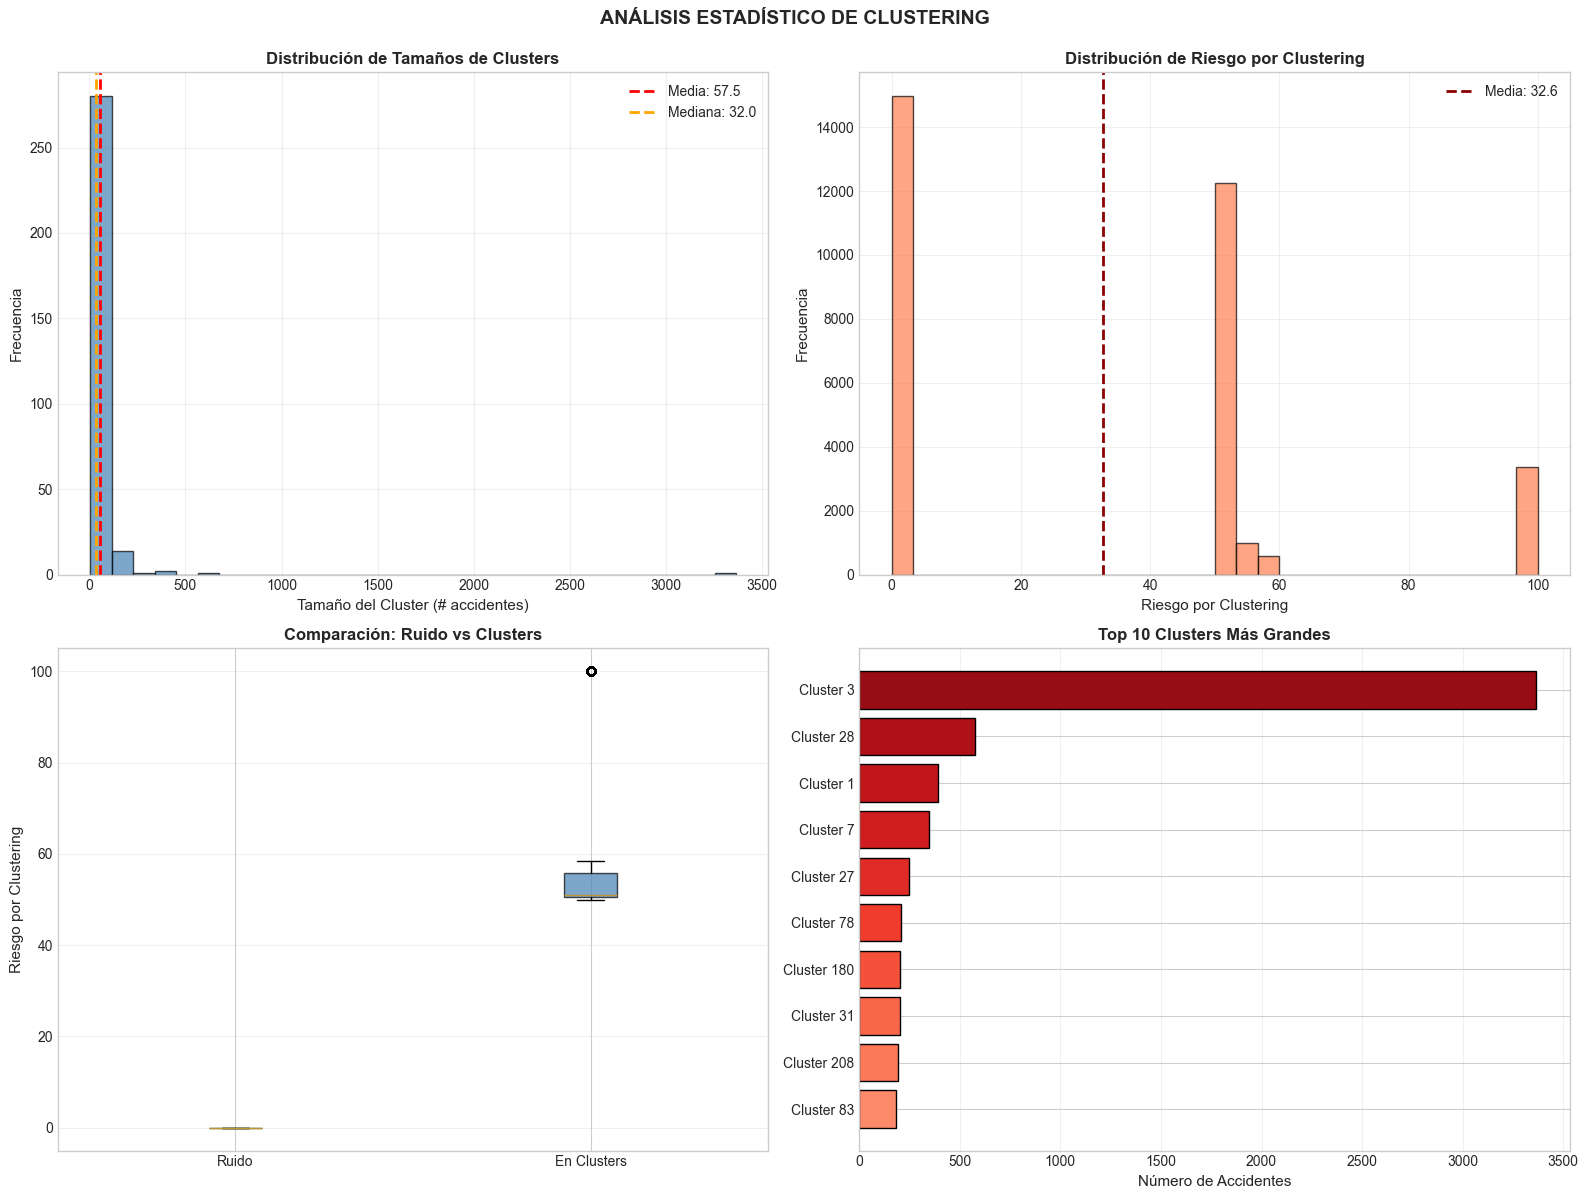

 Resumen Estadístico:
   Total de clusters: 299
   Tamaño promedio: 57.5 accidentes
   Tamaño mediano: 32.0 accidentes
   Cluster más grande: 3366 accidentes
   Cluster más pequeño: 3 accidentes


In [16]:
# Visualización de estadísticas de clustering
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distribución de tamaños de clusters
ax1 = axes[0, 0]
cluster_sizes = gdf_accidentes[gdf_accidentes["cluster_dbscan"] != -1].groupby("cluster_dbscan").size()
ax1.hist(cluster_sizes, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
ax1.set_xlabel("Tamaño del Cluster (# accidentes)", fontsize=11)
ax1.set_ylabel("Frecuencia", fontsize=11)
ax1.set_title("Distribución de Tamaños de Clusters", fontsize=12, fontweight="bold")
ax1.axvline(cluster_sizes.mean(), color="red", linestyle="--", linewidth=2, label=f"Media: {cluster_sizes.mean():.1f}")
ax1.axvline(cluster_sizes.median(), color="orange", linestyle="--", linewidth=2, label=f"Mediana: {cluster_sizes.median():.1f}")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Distribución de riesgo por clustering
ax2 = axes[0, 1]
ax2.hist(gdf_accidentes["riesgo_cluster"], bins=30, color="coral", edgecolor="black", alpha=0.7)
ax2.set_xlabel("Riesgo por Clustering", fontsize=11)
ax2.set_ylabel("Frecuencia", fontsize=11)
ax2.set_title("Distribución de Riesgo por Clustering", fontsize=12, fontweight="bold")
ax2.axvline(gdf_accidentes["riesgo_cluster"].mean(), color="darkred", linestyle="--", linewidth=2, 
           label=f"Media: {gdf_accidentes['riesgo_cluster'].mean():.1f}")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Boxplot comparativo
ax3 = axes[1, 0]
data_to_plot = [
    gdf_accidentes[gdf_accidentes["cluster_dbscan"] == -1]["riesgo_cluster"],
    gdf_accidentes[gdf_accidentes["cluster_dbscan"] != -1]["riesgo_cluster"]
]
bp = ax3.boxplot(data_to_plot, labels=["Ruido", "En Clusters"], patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightgray', 'steelblue']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_ylabel("Riesgo por Clustering", fontsize=11)
ax3.set_title("Comparación: Ruido vs Clusters", fontsize=12, fontweight="bold")
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Top 10 clusters más grandes
ax4 = axes[1, 1]
top_clusters = cluster_sizes.nlargest(10).sort_values(ascending=True)
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_clusters)))
ax4.barh(range(len(top_clusters)), top_clusters.values, color=colors, edgecolor="black")
ax4.set_yticks(range(len(top_clusters)))
ax4.set_yticklabels([f"Cluster {idx}" for idx in top_clusters.index])
ax4.set_xlabel("Número de Accidentes", fontsize=11)
ax4.set_title("Top 10 Clusters Más Grandes", fontsize=12, fontweight="bold")
ax4.grid(True, alpha=0.3, axis='x')

plt.suptitle("ANÁLISIS ESTADÍSTICO DE CLUSTERING", fontsize=14, fontweight="bold", y=0.995)
plt.tight_layout()
plt.show()

print(f" Resumen Estadístico:")
print(f"   Total de clusters: {len(cluster_sizes)}")
print(f"   Tamaño promedio: {cluster_sizes.mean():.1f} accidentes")
print(f"   Tamaño mediano: {cluster_sizes.median():.1f} accidentes")
print(f"   Cluster más grande: {cluster_sizes.max()} accidentes")
print(f"   Cluster más pequeño: {cluster_sizes.min()} accidentes")

## 7. Exportación de Resultados

In [17]:
# Exportación con columna ID para merge exacto en notebook 02
df_export_accidentes = gdf_accidentes[['id', 'latitud', 'longitud', 'cluster_dbscan', 'riesgo_cluster']].copy()
df_export_accidentes.to_csv('Datos combinados CDMX/ACCIDENTES_CON_CLUSTERING.csv', index=False)

grid_export = grid.copy()
grid_export['centroid_lat'] = grid_export.geometry.centroid.y
grid_export['centroid_lon'] = grid_export.geometry.centroid.x
grid_export[['centroid_lat', 'centroid_lon', 'n_accidentes', 'gi_score', 'hot_spot', 'riesgo_hotspot']].to_csv(
    'Datos combinados CDMX/GRID_HOTSPOTS.csv', index=False
)

print("✓ Datos exportados:")
print("   - Datos combinados CDMX/ACCIDENTES_CON_CLUSTERING.csv (con columna ID)")
print("   - Datos combinados CDMX/GRID_HOTSPOTS.csv")
print(f"\n Verificación de export:")
print(f"   Registros exportados: {len(df_export_accidentes):,}")
print(f"   Columnas: {list(df_export_accidentes.columns)}")

✓ Datos exportados:
   - Datos combinados CDMX/ACCIDENTES_CON_CLUSTERING.csv (con columna ID)
   - Datos combinados CDMX/GRID_HOTSPOTS.csv

 Verificación de export:
   Registros exportados: 32,139
   Columnas: ['id', 'latitud', 'longitud', 'cluster_dbscan', 'riesgo_cluster']


## Resumen

**Completado:**
- ✓ Clustering DBSCAN de puntos negros
- ✓ Hot spot analysis (Getis-Ord Gi*)
- ✓ Autocorrelación espacial (Moran's I)
- ✓ Índice de riesgo por clustering
- ✓ Archivos exportados para siguiente notebook

**Siguiente paso:** [02_modelado_ml_causas.ipynb](02_modelado_ml_causas.ipynb) - Análisis predictivo con Machine Learning